# Detecting Changeover with Machine Learning using NC Data and external Sensors

## 2-Phases Tuned

This notebook contains all the preliminary models used in the OBerA project.
It belongs to the article "Detecting Changeover with Machine Learning using NC Data and external Sensors" which can be found in Open Access by the following link: <https://www.mdpi.com/1424-8220/21/17/5896/htm>


## Packages used

Except for imblearn other packages used here are rather common for Anaconda distribution. Most of them are of the newest (or rather new) versions as of August 2021. You shall be able replicate the same results with the newest versions of these packages. However, below the version list of the packages used in the imports will be presented.

*For those interested, a 'requirements.txt' (generated by conda) file with all the packages used within the environment was also added to the project*


conda version : 4.10.3

python version : 3.9.6


pandas==1.3.2

numpy==1.21.2

matplotlib==3.4.3

seaborn==0.11.2

tensorflow==2.6.0

scikit-learn==0.24.2

imbalanced-learn==0.8.0

lightgbm==3.3.2

xgboost==1.5.2

# Imports


In [1]:
# Importing libraries
import pandas as pd #for working with dataframes
import numpy as np #for numerical and vector operations
import matplotlib as mpl #for visualization
import matplotlib.pyplot as plt #for visualization
import seaborn as sns #for visualization
import tensorflow as tf #for neural networks
from tensorflow import keras #for neural networks
import lightgbm as lgb #for light gradient boosting machine
import xgboost as xgb #for extreme gradient boosting 


# Metrics
from sklearn import metrics #metrics
from sklearn.metrics import classification_report #for F1 score and other metrics
from sklearn.metrics import f1_score #for F1 score specifically
from sklearn.metrics import matthews_corrcoef #for Matthews correlation coefficient (MCC)
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.metrics import roc_curve, roc_auc_score #ROC and AUC scores
from sklearn.metrics import ConfusionMatrixDisplay #for plotting confusion matrix

# Importing machine learning tools for preprocessing
from sklearn.model_selection import train_test_split #for splitting the data into training and test sets
from sklearn.preprocessing import StandardScaler #for feature scaling

# Models
from sklearn.tree import DecisionTreeClassifier #basic decision tree
from tensorflow.keras.optimizers import Adam #optimizer for neural networks
from imblearn.ensemble import BalancedRandomForestClassifier #balanced random forest classifier
from sklearn.ensemble import RandomForestClassifier #random forest classifier
from sklearn.ensemble import ExtraTreesClassifier #extra trees classifier
from sklearn.svm import SVC #support vector machine linear classifier
from catboost import CatBoostClassifier #cat boost classifier

# Function definition

Here we define a few functions that will be used to evaluate the models.


## ROC curve function
 

In [2]:
# Define the ROC curve function with graphical output

def plot_roc_curve(model):

    #setting up the parameters
    try:
        probs = model.predict(test_features)
        fpr, tpr, thresholds = roc_curve(test_labels, probs)
    except ValueError: #this is needed for Neural Network
        probs = np.argmax(model.predict(test_features, batch_size=1, verbose=0), axis=-1)
        fpr, tpr, thresholds = roc_curve(test_labels, probs)
        
    #plotting the ROC curve
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    #print AUC score
    print(f"AUC score: {roc_auc_score(test_labels, probs)}")

In [3]:
# Import data from csv
data = pd.read_csv("Data/Cleaned_Data.csv", sep= ',',header=0, index_col=0)
data.head()

,DateTime,ProgramStatus,ToolNumber,PocketTable,DriveStatus,DoorStatusTooling,OverrideFeed,FeedRate,SpindleSpeed,IndoorGPSx,IndoorGPSy,Phase,Phase_compressed,Production,outlier
0,2021-11-26 07:15:36,2.0,1.0,1.0,1.0,0.0,43.0,3440.0,2000.0,-0.262,0.886,20,4,0,1
1,2021-11-26 07:15:38,2.0,1.0,1.0,1.0,0.0,43.0,3440.0,1999.0,-0.251,0.840,20,4,0,1
2,2021-11-26 07:15:40,2.0,1.0,1.0,1.0,0.0,43.0,3440.0,1999.0,-0.234,0.724,20,4,0,1
6358,2021-11-26 07:15:41,2.0,1.0,1.0,1.0,0.0,43.0,3440.0,1999.0,-0.231,0.741,20,4,0,1
4,2021-11-26 07:15:44,2.0,1.0,1.0,1.0,0.0,43.0,3440.0,2000.0,-0.204,0.731,20,4,0,1


In [4]:
print(data.describe())

       ProgramStatus    ToolNumber   PocketTable   DriveStatus  \
count   20829.000000  20829.000000  20829.000000  20829.000000   
mean        1.416247     11.003217      4.727831      0.518124   
std         1.666373      8.439441      7.276607      0.499683   
min         0.000000      0.000000      0.000000      0.000000   
25%         0.000000      8.000000      0.000000      0.000000   
50%         2.000000      8.000000      0.000000      1.000000   
75%         2.000000     19.000000      8.000000      1.000000   
max         6.000000     32.000000     30.000000      1.000000   

       DoorStatusTooling  OverrideFeed      FeedRate  SpindleSpeed  \
count       20829.000000  20829.000000  20829.000000  20829.000000   
mean            0.041097     85.046090    510.249244   1692.612367   
std             0.198518     33.346662   2894.571722   2514.644846   
min             0.000000      0.000000 -32536.000000      0.000000   
25%             0.000000     81.000000      0.000000   

# Removing unnecessary columns

We need to ensure that our data contains entries useful for binary classification only. Everything else has to be discarded.


In [5]:
# Dropping the columns we do not need
df = data.copy()
df.pop('DateTime')
df.pop('Phase')
df.pop('Phase_compressed')
df.pop('outlier')
print(df)

       ProgramStatus  ToolNumber  PocketTable  DriveStatus  DoorStatusTooling  \
0                2.0         1.0          1.0          1.0                0.0   
1                2.0         1.0          1.0          1.0                0.0   
2                2.0         1.0          1.0          1.0                0.0   
6358             2.0         1.0          1.0          1.0                0.0   
4                2.0         1.0          1.0          1.0                0.0   
...              ...         ...          ...          ...                ...   
11002            0.0         8.0          8.0          0.0                0.0   
11003            0.0         8.0          8.0          0.0                0.0   
12252            0.0         8.0          8.0          0.0                0.0   
11004            0.0         8.0          8.0          0.0                0.0   
11005            0.0         8.0          8.0          0.0                0.0   

       OverrideFeed  FeedRa

# Data description


In [6]:
# Using the describe function to get 'raw' insights
df.describe()

,ProgramStatus,ToolNumber,PocketTable,DriveStatus,DoorStatusTooling,OverrideFeed,FeedRate,SpindleSpeed,IndoorGPSx,IndoorGPSy,Production
count,20829.000000,20829.000000,20829.000000,20829.000000,20829.000000,20829.000000,20829.000000,20829.000000,20829.000000,20829.000000,20829.000000
mean,1.416247,11.003217,4.727831,0.518124,0.041097,85.046090,510.249244,1692.612367,-0.480892,1.454996,0.525181
std,1.666373,8.439441,7.276607,0.499683,0.198518,33.346662,2894.571722,2514.644846,0.286149,0.941641,0.499377
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-32536.000000,0.000000,-1.304000,-0.783000,0.000000
25%,0.000000,8.000000,0.000000,0.000000,0.000000,81.000000,0.000000,0.000000,-0.697000,0.626000,0.000000
50%,2.000000,8.000000,0.000000,1.000000,0.000000,100.000000,0.000000,0.000000,-0.485000,1.508000,1.000000
75%,2.000000,19.000000,8.000000,1.000000,0.000000,100.000000,310.000000,4599.000000,-0.268000,1.914000,1.000000
max,6.000000,32.000000,30.000000,1.000000,1.000000,150.000000,32732.000000,10046.000000,0.178000,4.877000,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

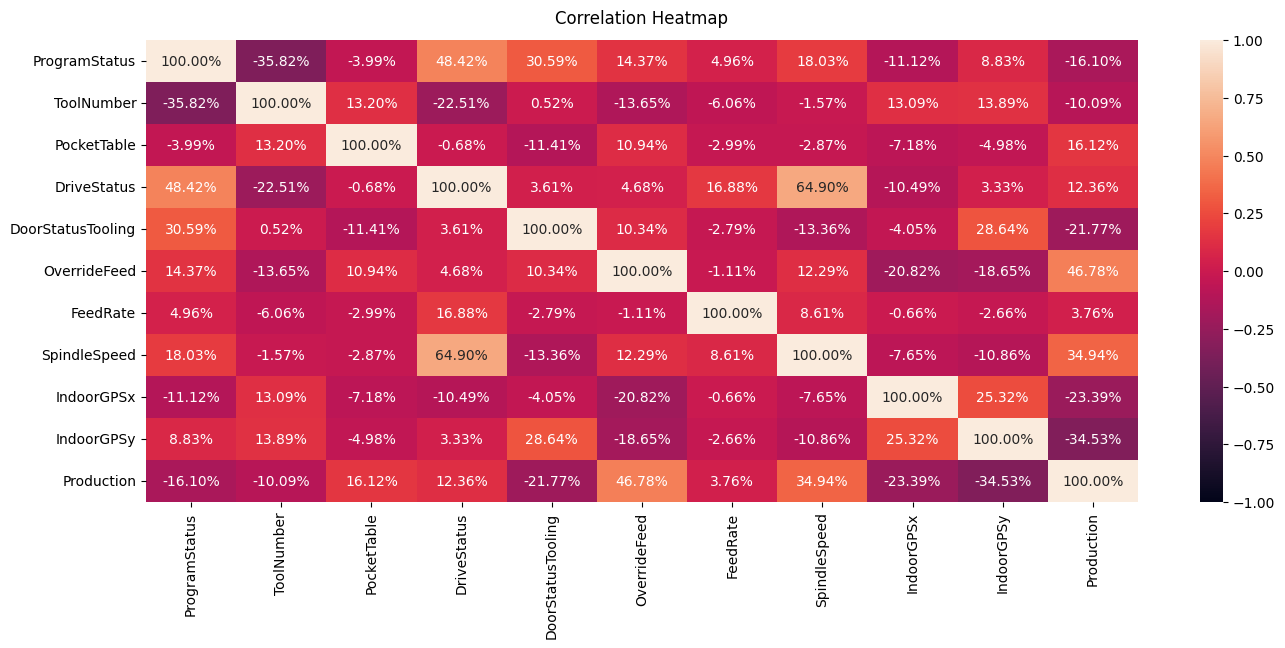

In [7]:
# Correlation heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, fmt='.2%')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)


# Data preparation


In [8]:
# Splitting the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

# Using numpy to create arrays of lables and features
train_labels = np.array(train_df['Production'])
test_labels = np.array(test_df['Production'])
train_features = np.array(train_df.iloc[:, 0:10])
test_features = np.array(test_df.iloc[:, 0:10])

# Scaling the features using Standard Scaler
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

# Having a look at the results
print('Training labels shape:', train_labels.shape)
print('Test labels shape:', test_labels.shape)
print('Training features shape:', train_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (16663,)
Test labels shape: (4166,)
Training features shape: (16663, 10)
Test features shape: (4166, 10)


In [9]:
train_labels

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

# Decision Tree


In [23]:
# Create a Decision Tree classifier object
clf_DT = DecisionTreeClassifier(random_state=0)

# Train Decision Tree Classifier
clf_DT = clf_DT.fit(train_features,train_labels)

# Predict the response for the test dataset
y_pred_DT = clf_DT.predict(test_features)

In [24]:
# Get the metrics for the Decision Tree
print(classification_report(test_labels,y_pred_DT))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1975
           1       0.99      0.99      0.99      2191

    accuracy                           0.99      4166
   macro avg       0.99      0.99      0.99      4166
weighted avg       0.99      0.99      0.99      4166



In [25]:
# Get macro average F1 score
f1_DT = f1_score(test_labels, y_pred_DT, average='macro')
f1_DT

0.9942232600448162

In [26]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_DT = matthews_corrcoef(test_labels, y_pred_DT)
MCC_DT

0.9884469808872764

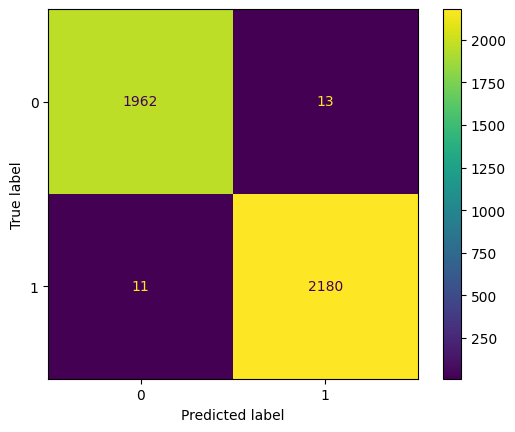

In [27]:
# Plot the confusion matrix for the Decision Tree
cm=confusion_matrix(test_labels,y_pred_DT,labels=[0,1])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot();

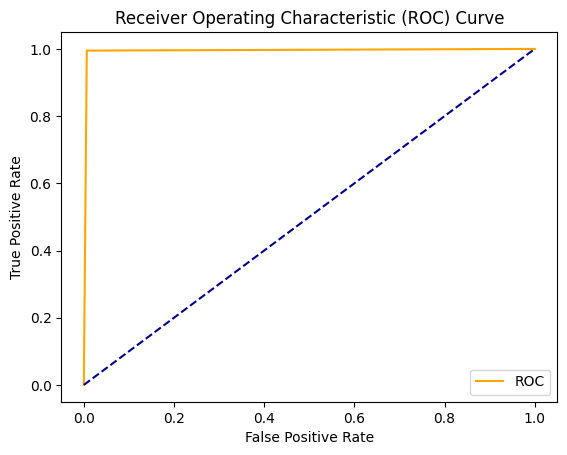

AUC score: 0.9941985914760615


In [28]:
# Plot the ROC curve and get the AUC score for the Decision Tree
plot_roc_curve(clf_DT)

# Neural Network


In [29]:
##split data in training and test data
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2,random_state=0)
train_NN_df, validation_df = train_test_split(train_df, test_size=0.125, random_state=0)

# Using numpy to create arrays of lables and features
train_NN_labels = np.array(train_NN_df['Production'])
validation_NN_labels = np.array(validation_df['Production'])
train_NN_features = np.array(train_NN_df.iloc[:, 0:10])
validation_NN_features = np.array(validation_df.iloc[:, 0:10])

# Form np arrays of labels and features.
test_NN_labels = np.array(test_df['Production'])
test_NN_features = np.array(test_df.iloc[:, 0:10])


scaler = StandardScaler()
train_NN_features = scaler.fit_transform(train_NN_features)
test_NN_features = scaler.transform(test_NN_features)
validation_NN_features = scaler.transform(validation_NN_features)

print('Training labels shape:', train_NN_labels.shape)
print('Test labels shape:', test_NN_labels.shape)
print('Validation labels shape:', validation_NN_labels.shape)
print('Training features shape:', train_NN_features.shape)
print('Test features shape:', test_NN_features.shape)
print('Validation features shape:', validation_NN_features.shape)

Training labels shape: (14580,)
Test labels shape: (4166,)
Validation labels shape: (2083,)
Training features shape: (14580, 10)
Test features shape: (4166, 10)
Validation features shape: (2083, 10)


In [30]:
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Nadam

def create_nn_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(300, activation='sigmoid', input_shape=(10,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3), # Prävention von Overfitting
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    
    #opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Nadam(learning_rate=0.01), metrics=['accuracy'])
    
    return model


clf_NN = KerasClassifier(model=create_nn_model, metrics=['accuracy'])

history = clf_NN.fit(train_NN_features,train_NN_labels, epochs=120, batch_size=64,validation_data=(validation_NN_features, validation_NN_labels))

# Predict the response for the test dataset
y_pred_NN = clf_NN.predict(test_NN_features,verbose=0)


Epoch 1/120
228/228 [==============================] - 3s 6ms/step - loss: 0.2184 - accuracy: 0.9187 - val_loss: 0.4807 - val_accuracy: 0.7811
Epoch 2/120
228/228 [==============================] - 1s 4ms/step - loss: 0.1492 - accuracy: 0.9445 - val_loss: 0.1359 - val_accuracy: 0.9429
Epoch 3/120
228/228 [==============================] - 1s 4ms/step - loss: 0.1226 - accuracy: 0.9546 - val_loss: 0.0802 - val_accuracy: 0.9698
Epoch 4/120
228/228 [==============================] - 1s 4ms/step - loss: 0.1075 - accuracy: 0.9621 - val_loss: 0.0733 - val_accuracy: 0.9774
Epoch 5/120
228/228 [==============================] - 1s 4ms/step - loss: 0.0999 - accuracy: 0.9652 - val_loss: 0.0716 - val_accuracy: 0.9784
Epoch 6/120
228/228 [==============================] - 1s 3ms/step - loss: 0.0980 - accuracy: 0.9658 - val_loss: 0.0774 - val_accuracy: 0.9774
Epoch 7/120
228/228 [==============================] - 1s 3ms/step - loss: 0.0855 - accuracy: 0.9703 - val_loss: 0.0757 - val_accuracy: 0.9741

In [31]:
# Get the metrics for the Neural Network
print(classification_report(test_NN_labels,y_pred_NN))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1975
           1       0.99      0.99      0.99      2191

    accuracy                           0.99      4166
   macro avg       0.99      0.99      0.99      4166
weighted avg       0.99      0.99      0.99      4166



In [32]:
# Get macro average F1 score
f1_NN = f1_score(test_NN_labels, y_pred_NN, average='macro')
f1_NN

0.9927783407079236

In [33]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_NN = matthews_corrcoef(test_NN_labels, y_pred_NN)
MCC_NN

0.985560823397884

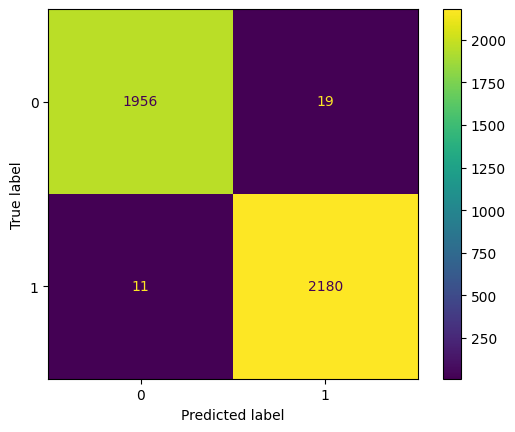

In [ ]:
# Plot the confusion matrix for the Neural Network
cm=confusion_matrix(test_NN_labels,y_pred_NN,labels=[0,1])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot();

131/131 [==============================] - 0s 2ms/step


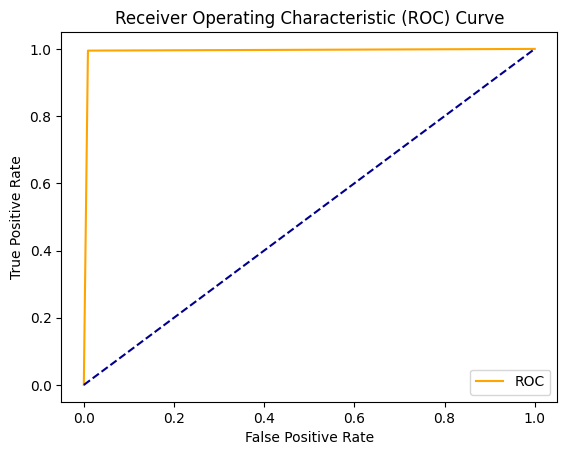

AUC score: 0.9929327686912512


In [ ]:
# Plot the ROC curve and get the AUC score for the Neural Network
plot_roc_curve(clf_NN)

# Balanced Random Forest


In [34]:
# Create a Balanced Random Forest classifier object
clf_BRF = BalancedRandomForestClassifier(n_estimators=100, random_state=42, sampling_strategy='auto', replacement=False, bootstrap=True)

# Train the Balanced Random Forest Classifier
clf_BRF = clf_BRF.fit(train_features,train_labels)

# Predict the response for the test dataset
y_pred_BRF = clf_BRF.predict(test_features)

In [35]:
# Get the metrics for the Balanced Random Forest
print(classification_report(test_labels,y_pred_BRF))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1975
           1       0.99      1.00      0.99      2191

    accuracy                           0.99      4166
   macro avg       0.99      0.99      0.99      4166
weighted avg       0.99      0.99      0.99      4166



In [36]:
# Get macro average F1 score
f1_BRF = f1_score(test_labels, y_pred_BRF, average='macro')
f1_BRF

0.9942226725663389

In [37]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_BRF = matthews_corrcoef(test_labels, y_pred_BRF)
MCC_BRF

0.9884494931578647

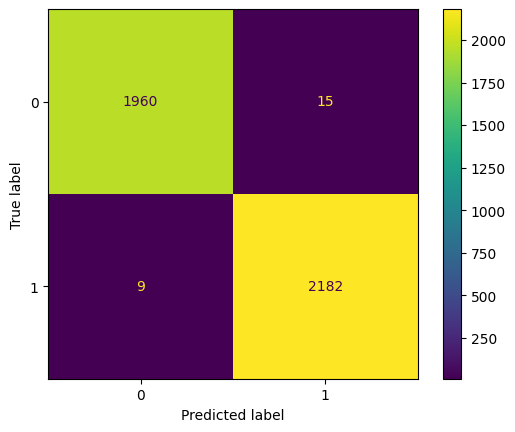

In [38]:
# Plot the confusion matrix for the Balanced Random Forest
cm=confusion_matrix(test_labels,y_pred_BRF,labels=[0,1])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot();

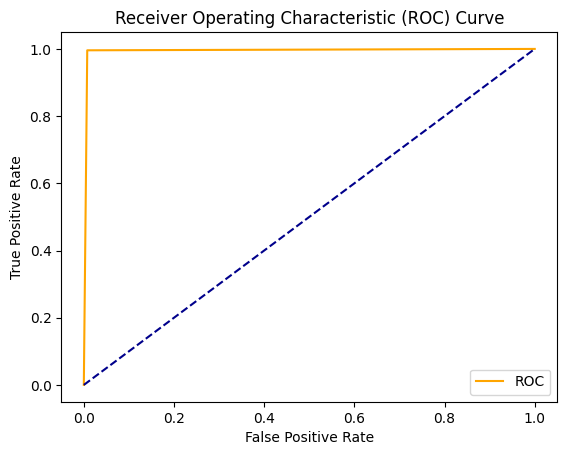

AUC score: 0.994148674959125


In [39]:
# Plot the ROC curve and get the AUC score for the Balanced Random Forest
plot_roc_curve(clf_BRF)

# Random Forest

Parameters didn't change after tuning

In [40]:
# Create a Random Forest classifier object with best parameters found via grid search
clf_RF = RandomForestClassifier(random_state=0)

# Train the Random Forest Classifier
clf_RF = clf_RF.fit(train_features, train_labels)

# Predict the response for the test dataset
y_pred_RF = clf_RF.predict(test_features)

In [41]:
# Get the metrics for the Random Tree
print(classification_report(test_labels,y_pred_RF))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1975
           1       0.99      1.00      0.99      2191

    accuracy                           0.99      4166
   macro avg       0.99      0.99      0.99      4166
weighted avg       0.99      0.99      0.99      4166



In [42]:
# Get macro average F1 score
f1_RF = f1_score(test_labels, y_pred_RF, average='macro')
f1_RF

0.9944626762313767

In [43]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_RF = matthews_corrcoef(test_labels, y_pred_RF)
MCC_RF

0.9889393014893129

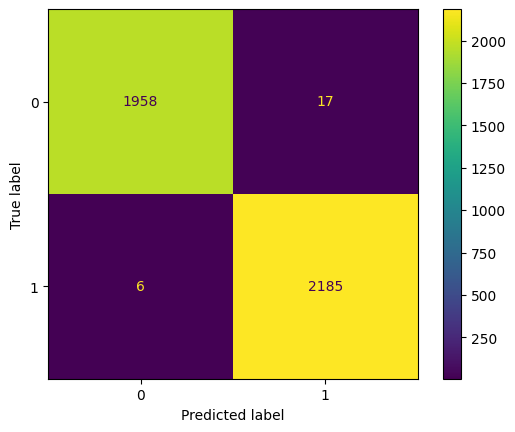

In [44]:
# Plot the confusion matrix for the Random Forest
cm=confusion_matrix(test_labels,y_pred_RF,labels=[0,1])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot();

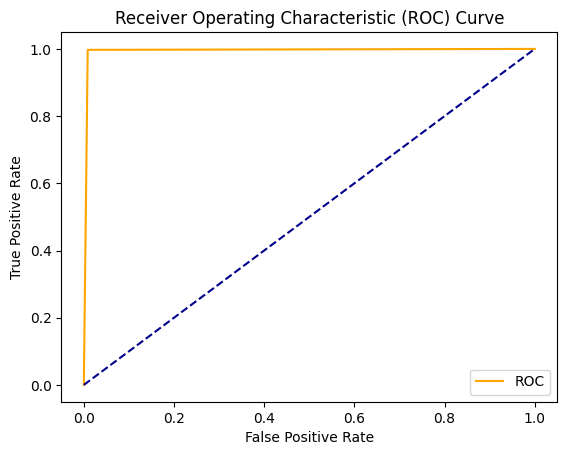

AUC score: 0.9943269647406825


In [45]:
# Plot the ROC curve and get the AUC score for the Random Forest
plot_roc_curve(clf_RF)

# Extra trees

Parameters didn't change after tuning


In [46]:
# Create an Extra Trees classifier object
clf_ET = ExtraTreesClassifier(n_jobs=-1,random_state=0)

# Train Extra Trees Classifier
clf_ET = clf_ET.fit(train_features,train_labels)

# Predict the response for the test dataset
y_pred_ET = clf_ET.predict(test_features)

In [47]:
# Get the metrics for the Extra Trees
print(classification_report(test_labels,y_pred_ET))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1975
           1       1.00      1.00      1.00      2191

    accuracy                           1.00      4166
   macro avg       1.00      1.00      1.00      4166
weighted avg       1.00      1.00      1.00      4166



In [48]:
# Get macro average F1 score
f1_ET = f1_score(test_labels, y_pred_ET, average='macro')
f1_ET

0.9971116300224081

In [49]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_ET = matthews_corrcoef(test_labels, y_pred_ET)
MCC_ET

0.9942237221848347

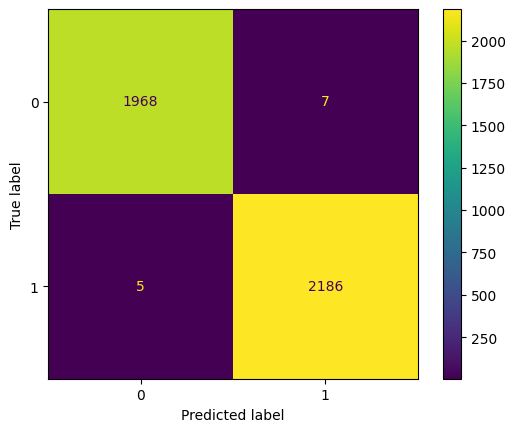

In [50]:
# Plot the confusion matrix for the Extra Trees
cm=confusion_matrix(test_labels,y_pred_ET,labels=[0,1])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot();

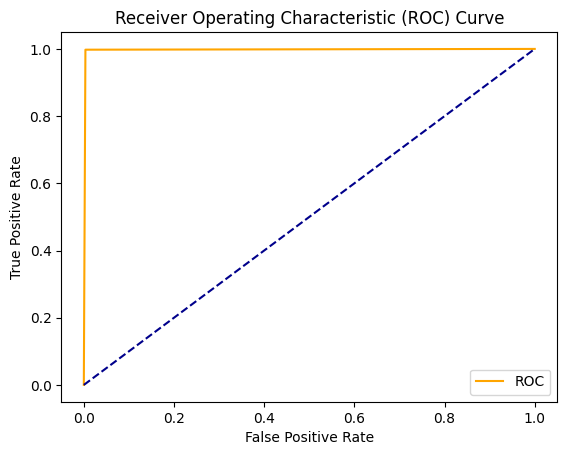

AUC score: 0.9970868166087966


In [51]:
# Plot the ROC curve and get the AUC score for the Decision Tree
plot_roc_curve(clf_ET)

# SVC


In [52]:
# Create an SVC classifier object
clf_SVC = SVC(kernel='rbf', C=100000,random_state=0)

# Train the SVC Classifier
clf_SVC = clf_SVC.fit(train_features, train_labels)

# Predict the response for the test dataset
y_pred_SVC = clf_SVC.predict(test_features)

In [53]:
# Get the metrics for the SVC
print(classification_report(test_labels,y_pred_SVC))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1975
           1       0.99      0.99      0.99      2191

    accuracy                           0.99      4166
   macro avg       0.99      0.99      0.99      4166
weighted avg       0.99      0.99      0.99      4166



In [54]:
# Get macro average F1 score
f1_SVC = f1_score(test_labels, y_pred_SVC, average='macro')
f1_SVC

0.9874830965873307

In [55]:
# Calculate Matthews Correlation coefficient (for future use)
MCC_SVC = matthews_corrcoef(test_labels, y_pred_SVC)
MCC_SVC

0.9749680240206638

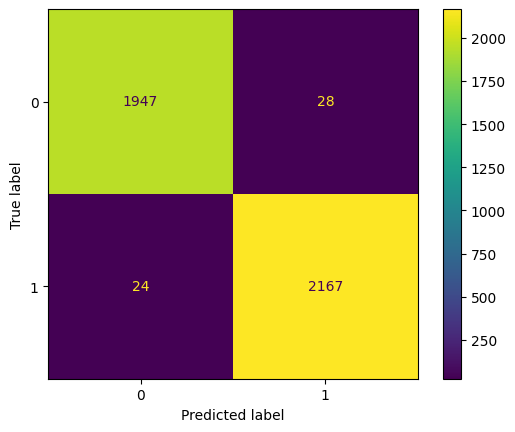

In [63]:
# Plot the confusion matrix for the SVC
cm=confusion_matrix(test_labels,y_pred_SVC,labels=[0,1])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot();

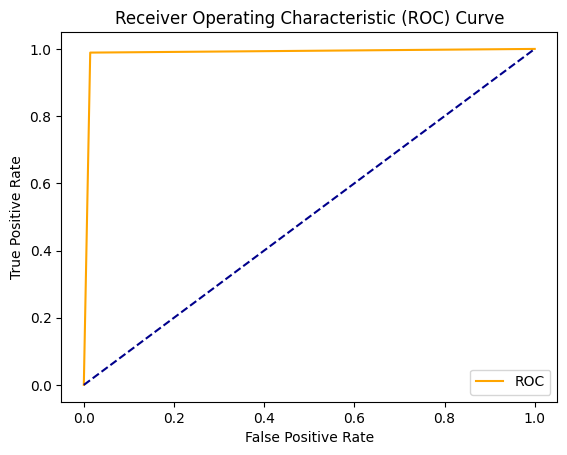

AUC score: 0.987434441241211


In [64]:
# Plot the ROC curve and get the AUC score for the SVC
plot_roc_curve(clf_SVC)

# Cat Boost

In [65]:
clf_cat = CatBoostClassifier(iterations=260, depth=9, loss_function='Logloss', random_seed=0, 
                             random_strength=0.7,eta=0.3, sampling_frequency='PerTree')

clf_cat.fit(train_features, train_labels, verbose=False)

In [66]:
y_pred_cat = clf_cat.predict(test_features)
y_pred_cat

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [67]:
print(classification_report(test_labels,y_pred_cat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1975
           1       1.00      1.00      1.00      2191

    accuracy                           1.00      4166
   macro avg       1.00      1.00      1.00      4166
weighted avg       1.00      1.00      1.00      4166



In [68]:
# Get macro average F1 score
f1_CAT= f1_score(test_labels, y_pred_cat, average='macro')
f1_CAT

0.9966300644658198

In [60]:
MCC_CAT = matthews_corrcoef(test_labels, y_pred_cat)
MCC_CAT

0.9932619767845006

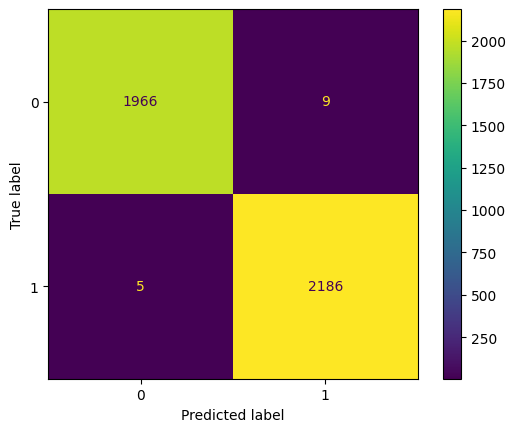

In [61]:
# Plot the confusion matrix for Catboost
cm=confusion_matrix(test_labels,y_pred_cat,labels=[0,1])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot();

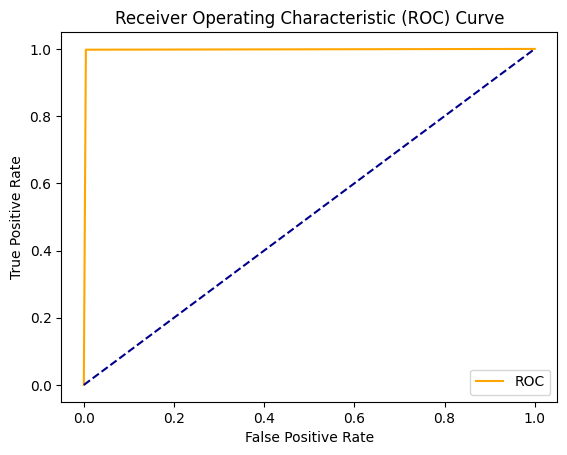

AUC score: 0.9965804874948726


In [62]:
# Plot the ROC curve and get the AUC score for Catboost
plot_roc_curve(clf_cat)

# LightGBM 

Parameter didn't change after tuning

In [69]:
clf_gbm=lgb.LGBMClassifier(random_state=0)
clf_gbm.fit(train_features,train_labels)

[LightGBM] [Info] Number of positive: 8748, number of negative: 7915
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 16663, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.524995 -> initscore=0.100065
[LightGBM] [Info] Start training from score 0.100065


LGBMClassifier(random_state=0)

In [70]:
y_pred_gbm = clf_gbm.predict(test_features)
y_pred_gbm

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [71]:
print(classification_report(test_labels,y_pred_gbm))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1975
           1       0.99      1.00      1.00      2191

    accuracy                           1.00      4166
   macro avg       1.00      1.00      1.00      4166
weighted avg       1.00      1.00      1.00      4166



In [72]:
# Get macro average F1 score
f1_GBM = f1_score(test_labels, y_pred_gbm, average='macro')
f1_GBM

0.9954266320652869

In [73]:
MCC_GBM = matthews_corrcoef(test_labels, y_pred_gbm)
MCC_GBM

0.9908543022362309

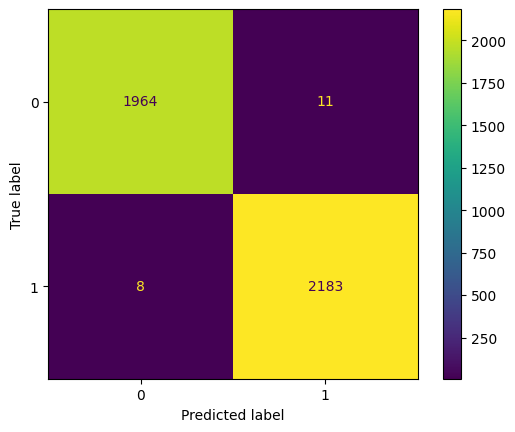

In [74]:
# Plot the confusion matrix for Light Gradient Boosting
cm=confusion_matrix(test_labels,y_pred_gbm,labels=[0,1])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot();

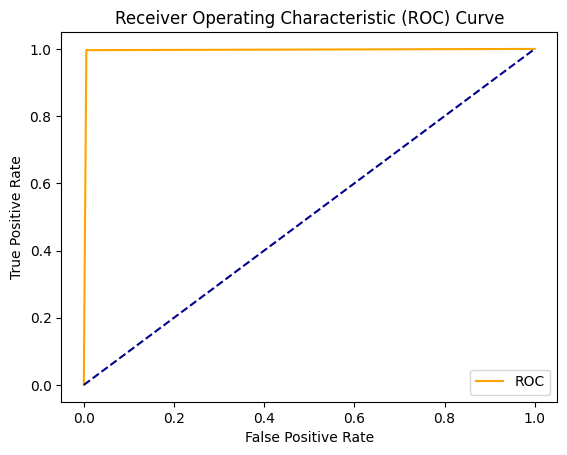

AUC score: 0.995389539485467


In [75]:
# Plot the ROC curve and get the AUC score for Light Gradient Boosting
plot_roc_curve(clf_gbm)

## Extreme Gradient Boost


In [82]:
clf_xgb=xgb.XGBClassifier(objective='binary:logistic',random_state=0, verbosity=0);
clf_xgb.fit(train_features,train_labels);

In [83]:
y_pred_xgb = clf_xgb.predict(test_features)
y_pred_xgb

array([0, 0, 1, ..., 1, 0, 0])

In [84]:
print(classification_report(test_labels,y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1975
           1       1.00      1.00      1.00      2191

    accuracy                           1.00      4166
   macro avg       1.00      1.00      1.00      4166
weighted avg       1.00      1.00      1.00      4166



In [86]:
f1_XGB = f1_score(test_labels, y_pred_xgb, average='macro')
f1_XGB

0.9961490331563532

In [87]:
MCC_XGB = matthews_corrcoef(test_labels, y_pred_xgb)
MCC_XGB

0.9922980663127062

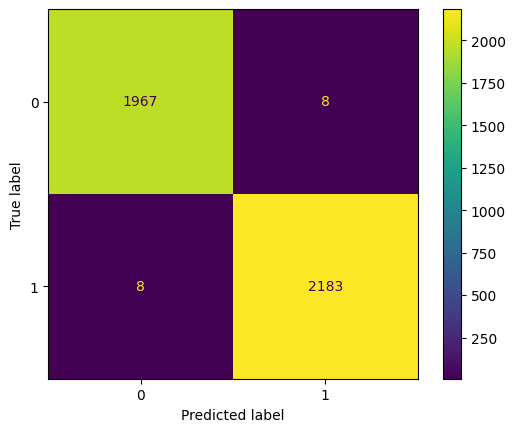

In [88]:
# Plot the confusion matrix for Extreme Gradient Boosting
cm=confusion_matrix(test_labels,y_pred_xgb,labels=[0,1])
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot();

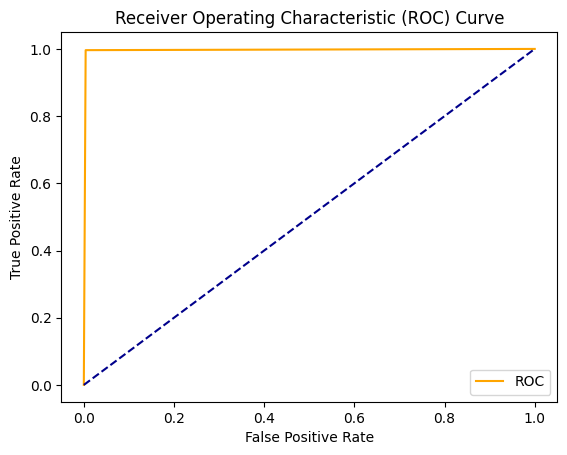

AUC score: 0.9961490331563532


In [89]:
# Plot the ROC curve and get the AUC score for Extreme Gradient Boosting
plot_roc_curve(clf_xgb)

# Comparison tables

Cells below contain code to create a nice-looking table which compares F1, AUC and MCC of all algorithms used in OBerA.


In [96]:
# Create a skeleton of the table
comp_table = pd.DataFrame(index=['Neural Network', 'SVC', 'Decision Tree', 'Balanced Random Forest', 'Random Forest', 'Extra Trees','Catboost','LightGBM','XGBoost'], columns=['F1 score', 'AUC score', 'MCC'])

In [97]:
# Add values to the table
comp_table.iloc[0] = [f1_NN, roc_auc_score(test_labels, y_pred_NN), MCC_NN]
comp_table.iloc[1] = [f1_SVC, roc_auc_score(test_labels, y_pred_SVC), MCC_SVC] #if needed, put your SVC values here or simply remove "_static" from each parameter
comp_table.iloc[2] = [f1_DT, roc_auc_score(test_labels, y_pred_DT), MCC_DT]
comp_table.iloc[3] = [f1_BRF, roc_auc_score(test_labels, y_pred_BRF), MCC_BRF]
comp_table.iloc[4] = [f1_RF, roc_auc_score(test_labels, y_pred_RF), MCC_RF]
comp_table.iloc[5] = [f1_ET, roc_auc_score(test_labels, y_pred_ET), MCC_ET]
comp_table.iloc[6] = [f1_CAT, roc_auc_score(test_labels, y_pred_ET), MCC_CAT]
comp_table.iloc[7] = [f1_GBM, roc_auc_score(test_labels, y_pred_ET), MCC_GBM]
comp_table.iloc[8] = [f1_XGB, roc_auc_score(test_labels, y_pred_ET), MCC_XGB]

In [98]:
# Round all the values down to two digits
for i in range(len(comp_table)):
    comp_table.iloc[i] = comp_table.iloc[i].apply(lambda x: round(x, 5))

In [99]:
# Show the table
comp_table

,F1 score,AUC score,MCC
Neural Network,0.99278,0.9927,0.98556
SVC,0.98748,0.98743,0.97497
Decision Tree,0.99422,0.9942,0.98845
Balanced Random Forest,0.99422,0.99415,0.98845
Random Forest,0.99446,0.99433,0.98894
Extra Trees,0.99711,0.99709,0.99422
Catboost,0.99663,0.99709,0.99326
LightGBM,0.99543,0.99709,0.99085
XGBoost,0.99615,0.99709,0.9923
